In [1]:
%matplotlib inline


# LDA Model

Introduces Gensim's LDA model and demonstrates its use on the NIPS corpus.


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
import pandas as pd
import numpy as np

In [4]:
df=pd.read_csv('../data/clean/rel_deu_clean.csv')

In [5]:
df.head()

Unnamed: 0        date        year  \
0           0  2021-06-01  2021-01-01   
1           1  2021-04-01  2021-01-01   
2           2  2020-05-01  2020-01-01   
3           3  2021-01-01  2021-01-01   
4           4  2021-05-01  2021-01-01   

                                              f_name  \
0  ../data/rel_DEU/Anthroposophen/Anth_Rest/2021-...   
1  ../data/rel_DEU/Anthroposophen/Anth_Rest/2021-...   
2  ../data/rel_DEU/Anthroposophen/Anth_randomSamp...   
3  ../data/rel_DEU/Anthroposophen/Anth_randomSamp...   
4  ../data/rel_DEU/Anthroposophen/Anth_randomSamp...   

                                             raw_txt  \
0  *** Date of publication: 06/2021 Link: AGiD Ne...   
1  *** Date of publication: 04/2021 Link: AGiD Ne...   
2  *** Date of publication: 05/2020 Link: AGiD Ne...   
3  *** Date of publication: 01/2021 Link: AGiD Ne...   
4  *** Date of publication: 05/2021 Link: AGiD Ne...   

                                               txt_1  len_text  \
0  Kurz nach dem ersten coronabedingten Lockdown ...      1134   
1  In diesem Beitrag beschreibt Christine Rüter, ...      1123   
2  Das Arbeitskollegium der Anthroposophischen Ge...       892   
3  Ich erinnere mich noch gut an den Jahresbeginn...       849   
4  Das Signum der Corona-Zeit kann als Weckruf ve...       307   

                                         cleaned_txt Denomination  
0  Kurz nach dem ersten coronabedingten Lockdown ...      Anthrop  
1  In diesem Beitrag beschreibt Christine Rüter V...      Anthrop  
2  Das Arbeitskollegium der Anthroposophischen Ge...      Anthrop  
3  Ich erinnere mich noch gut an den Jahresbeginn...      Anthrop  
4  Das Signum der CoronaZeit kann als Weckruf ver...      Anthrop

In [6]:
docs=df['cleaned_txt'].to_list()

## Pre-process and vectorize the documents

As part of preprocessing, we will:

* Tokenize (split the documents into tokens).
* Lemmatize the tokens.
* Compute bigrams.
* Compute a bag-of-words representation of the data.

First we tokenize the text using a regular expression tokenizer from NLTK. We
remove numeric tokens and tokens that are only a single character, as they
don't tend to be useful, and the dataset contains a lot of them.

.. Important::

   This tutorial uses the nltk library for preprocessing, although you can
   replace it with something else if you want.




In [7]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 2] for doc in docs]

We use the WordNet lemmatizer from NLTK. A lemmatizer is preferred over a
stemmer in this case because it produces more readable words. Output that is
easy to read is very desirable in topic modelling.




In [8]:
import nltk
from nltk.corpus import stopwords
# Lemmatize the documents.
# from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Add your custom stopwords
custom_stopwords = ['get', 'really', 'back', 'mr','fr','let','get','see','lot','might','keep','different','able','something','continue','use','every',
                     'frage', 'sagt', 'mal', 'ganz', 'zwei', 'vielleicht', 'natürlich', 
    'leute', 'einfach', 'kommen', 'gemeinde', 'wer', 'sagen', 
    'gehen', 'vielen', 'beispiel', 'welt', 'zeitung', 'Zeitung','islamische_zeitung'  
                   ]

# Extend the NLTK stopwords list with your custom stopwords
stop_words = set(stopwords.words('german')).union(custom_stopwords)

# Remove stopwords and lemmatize tokens in each document
docs = [
    [lemmatizer.lemmatize(token) for token in doc if token not in stop_words]
    for doc in docs
]

We find bigrams in the documents. Bigrams are sets of two adjacent words.
Using bigrams we can get phrases like "machine_learning" in our output
(spaces are replaced with underscores); without bigrams we would only get
"machine" and "learning".

Note that in the code below, we find bigrams and then add them to the
original data, because we would like to keep the words "machine" and
"learning" as well as the bigram "machine_learning".

.. Important::
    Computing n-grams of large dataset can be very computationally
    and memory intensive.




In [9]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

2024-01-19 09:33:09,440 : INFO : collecting all words and their counts
2024-01-19 09:33:09,447 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2024-01-19 09:33:09,872 : INFO : collected 283149 token types (unigram + bigrams) from a corpus of 282116 words and 797 sentences
2024-01-19 09:33:09,872 : INFO : merged Phrases<283149 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
2024-01-19 09:33:09,873 : INFO : Phrases lifecycle event {'msg': 'built Phrases<283149 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.43s', 'datetime': '2024-01-19T09:33:09.873443', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


We remove rare words and common words based on their *document frequency*.
Below we remove words that appear in less than 20 documents or in more than
50% of the documents. Consider trying to remove words only based on their
frequency, or maybe combining that with this approach.




In [10]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.3)

2024-01-19 09:33:10,349 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-01-19 09:33:10,692 : INFO : built Dictionary<43214 unique tokens: ['agid', 'aktiven', 'angelangt', 'anliegen', 'anschluss']...> from 797 documents (total 285374 corpus positions)
2024-01-19 09:33:10,693 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<43214 unique tokens: ['agid', 'aktiven', 'angelangt', 'anliegen', 'anschluss']...> from 797 documents (total 285374 corpus positions)", 'datetime': '2024-01-19T09:33:10.693858', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2024-01-19 09:33:10,731 : INFO : discarding 39151 tokens: [('angelangt', 2), ('ansteht', 5), ('anthroposphen', 1), ('arbeitete', 8), ('austritt', 1), ('austritts', 2), ('auszudrücken', 7), ('baues', 1), ('belange', 5), ('bequemlichkeit', 2)]...
2024-01-19 09:33:10,732 : INFO : keeping 4063 tokens which were in no 

Finally, we transform the documents to a vectorized form. We simply compute
the frequency of each word, including the bigrams.




In [11]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

Let's see how many tokens and documents we have to train on.




In [12]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4063
Number of documents: 797


## Training

We are ready to train the LDA model. We will first discuss how to set some of
the training parameters.

First of all, the elephant in the room: how many topics do I need? There is
really no easy answer for this, it will depend on both your data and your
application. I have used 10 topics here because I wanted to have a few topics
that I could interpret and "label", and because that turned out to give me
reasonably good results. You might not need to interpret all your topics, so
you could use a large number of topics, for example 100.

``chunksize`` controls how many documents are processed at a time in the
training algorithm. Increasing chunksize will speed up training, at least as
long as the chunk of documents easily fit into memory. I've set ``chunksize =
2000``, which is more than the amount of documents, so I process all the
data in one go. Chunksize can however influence the quality of the model, as
discussed in Hoffman and co-authors [2], but the difference was not
substantial in this case.

``passes`` controls how often we train the model on the entire corpus.
Another word for passes might be "epochs". ``iterations`` is somewhat
technical, but essentially it controls how often we repeat a particular loop
over each document. It is important to set the number of "passes" and
"iterations" high enough.

I suggest the following way to choose iterations and passes. First, enable
logging (as described in many Gensim tutorials), and set ``eval_every = 1``
in ``LdaModel``. When training the model look for a line in the log that
looks something like this::

   2016-06-21 15:40:06,753 - gensim.models.ldamodel - DEBUG - 68/1566 documents converged within 400 iterations

If you set ``passes = 20`` you will see this line 20 times. Make sure that by
the final passes, most of the documents have converged. So you want to choose
both passes and iterations to be high enough for this to happen.

We set ``alpha = 'auto'`` and ``eta = 'auto'``. Again this is somewhat
technical, but essentially we are automatically learning two parameters in
the model that we usually would have to specify explicitly.




In [13]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 8
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2024-01-19 09:33:10,946 : INFO : using autotuned alpha, starting with [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
2024-01-19 09:33:10,949 : INFO : using serial LDA version on this node
2024-01-19 09:33:10,955 : INFO : running online (multi-pass) LDA training, 8 topics, 20 passes over the supplied corpus of 797 documents, updating model once every 797 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2024-01-19 09:33:10,957 : INFO : PROGRESS: pass 0, at document #797/797
2024-01-19 09:33:14,388 : INFO : optimized alpha [0.06628404, 0.09892797, 0.06802955, 0.050897896, 0.065871045, 0.0681193, 0.07124047, 0.07814717]
2024-01-19 09:33:14,392 : INFO : topic #3 (0.051): 0.004*"macht" + 0.003*"bischof" + 0.003*"frau" + 0.002*"heute" + 0.002*"dafür" + 0.002*"darauf" + 0.002*"besonders" + 0.002*"deutschen" + 0.002*"gemeinden" + 0.002*"katholische"
2024-01-19 09:33:14,393 : INFO : topic #4 (0.066): 0.003*"möglich" + 0.003*"si

We can compute the topic coherence of each topic. Below we display the
average topic coherence and print the topics in order of topic coherence.

Note that we use the "Umass" topic coherence measure here (see
:py:func:`gensim.models.ldamodel.LdaModel.top_topics`), Gensim has recently
obtained an implementation of the "AKSW" topic coherence measure (see
accompanying blog post, http://rare-technologies.com/what-is-topic-coherence/).

If you are familiar with the subject of the articles in this dataset, you can
see that the topics below make a lot of sense. However, they are not without
flaws. We can see that there is substantial overlap between some topics,
others are hard to interpret, and most of them have at least some terms that
seem out of place. If you were able to do better, feel free to share your
methods on the blog at http://rare-technologies.com/lda-training-tips/ !




In [16]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
# avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
# print('Average topic coherence: %.4f.' % avg_topic_coherence)

# from pprint import pprint
# pprint(top_topics)
# topics = model.show_topics()

In [17]:
top_topics[0]

([(0.008416895, 'meinung'),
  (0.007991282, 'kommentar'),
  (0.007927839, 'frau'),
  (0.0070265005, 'standpunkt'),
  (0.0069972454, 'wider'),
  (0.0068962453, 'spiegelt'),
  (0.0066904435, 'hinweis'),
  (0.0066764746, 'hinweis_standpunkt'),
  (0.006356896, 'unbedingt'),
  (0.0060487767, 'katholischde'),
  (0.005753152, 'redaktion'),
  (0.005248633, 'meinung_redaktion'),
  (0.005248603, 'katholischde_wider'),
  (0.0052484656, 'spiegelt_unbedingt'),
  (0.004809363, 'autor'),
  (0.004415631, 'macht'),
  (0.00425318, 'wäre'),
  (0.0035713995, 'virus'),
  (0.0034083873, 'gesellschaft'),
  (0.0033562074, 'krise')],
 -0.9252682882377573)

In [18]:
top_topics = model.top_topics(corpus)
top_topics

[([(0.008416895, 'meinung'),
   (0.007991282, 'kommentar'),
   (0.007927839, 'frau'),
   (0.0070265005, 'standpunkt'),
   (0.0069972454, 'wider'),
   (0.0068962453, 'spiegelt'),
   (0.0066904435, 'hinweis'),
   (0.0066764746, 'hinweis_standpunkt'),
   (0.006356896, 'unbedingt'),
   (0.0060487767, 'katholischde'),
   (0.005753152, 'redaktion'),
   (0.005248633, 'meinung_redaktion'),
   (0.005248603, 'katholischde_wider'),
   (0.0052484656, 'spiegelt_unbedingt'),
   (0.004809363, 'autor'),
   (0.004415631, 'macht'),
   (0.00425318, 'wäre'),
   (0.0035713995, 'virus'),
   (0.0034083873, 'gesellschaft'),
   (0.0033562074, 'krise')],
  -0.9252682882377573),
 ([(0.0064969487, 'glaube'),
   (0.0053586266, 'wirklich'),
   (0.004863319, 'situation'),
   (0.0048481403, 'krise'),
   (0.0047917548, 'gesagt'),
   (0.004702782, 'moment'),
   (0.004436468, 'hoffnung'),
   (0.0040127626, 'eigentlich'),
   (0.003779968, 'gottesdienst'),
   (0.003546337, 'wichtig'),
   (0.0035103175, 'fragen'),
   (0.00

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [20]:
for n in range(model.num_topics):
    print(model.show_topic(n))

[('kinder', 0.0053388984), ('gott', 0.0049066404), ('macht', 0.0040800553), ('heute', 0.0039257505), ('kommt', 0.0036940435), ('jahren', 0.003197988), ('oft', 0.0031899873), ('neue', 0.003122172), ('virus', 0.002951287), ('familien', 0.0029180134)]
[('prozent', 0.0065663443), ('millionen', 0.0054821107), ('deutschen', 0.0044457586), ('euro', 0.00443083), ('bistum', 0.004017197), ('kna', 0.0038934886), ('hätten', 0.0037896545), ('wegen', 0.003782399), ('bischof', 0.0037506672), ('rund', 0.0037095665)]
[('allah', 0.014726015), ('impfen', 0.009991621), ('impfung', 0.009894021), ('lassen', 0.007260779), ('steiner', 0.0054957154), ('impfen_lassen', 0.0051099164), ('impfpflicht', 0.0047712573), ('rudolf', 0.0045260927), ('impfstoffe', 0.004500752), ('gesundheit', 0.0042367475)]
[('meinung', 0.008416895), ('kommentar', 0.007991282), ('frau', 0.007927839), ('standpunkt', 0.0070265005), ('wider', 0.0069972454), ('spiegelt', 0.0068962453), ('hinweis', 0.0066904435), ('hinweis_standpunkt', 0.0066

In [23]:
topic_names = [
    "Children, Crisis, and Faith",
    "German Economy",
    "Vaccines",
    "Catholic Media",
    "Religious Struggles",
    "Church Leadership and Challenges",
        "Islamic Community and Politics",
    "Religious Practices and Celebrations"
]

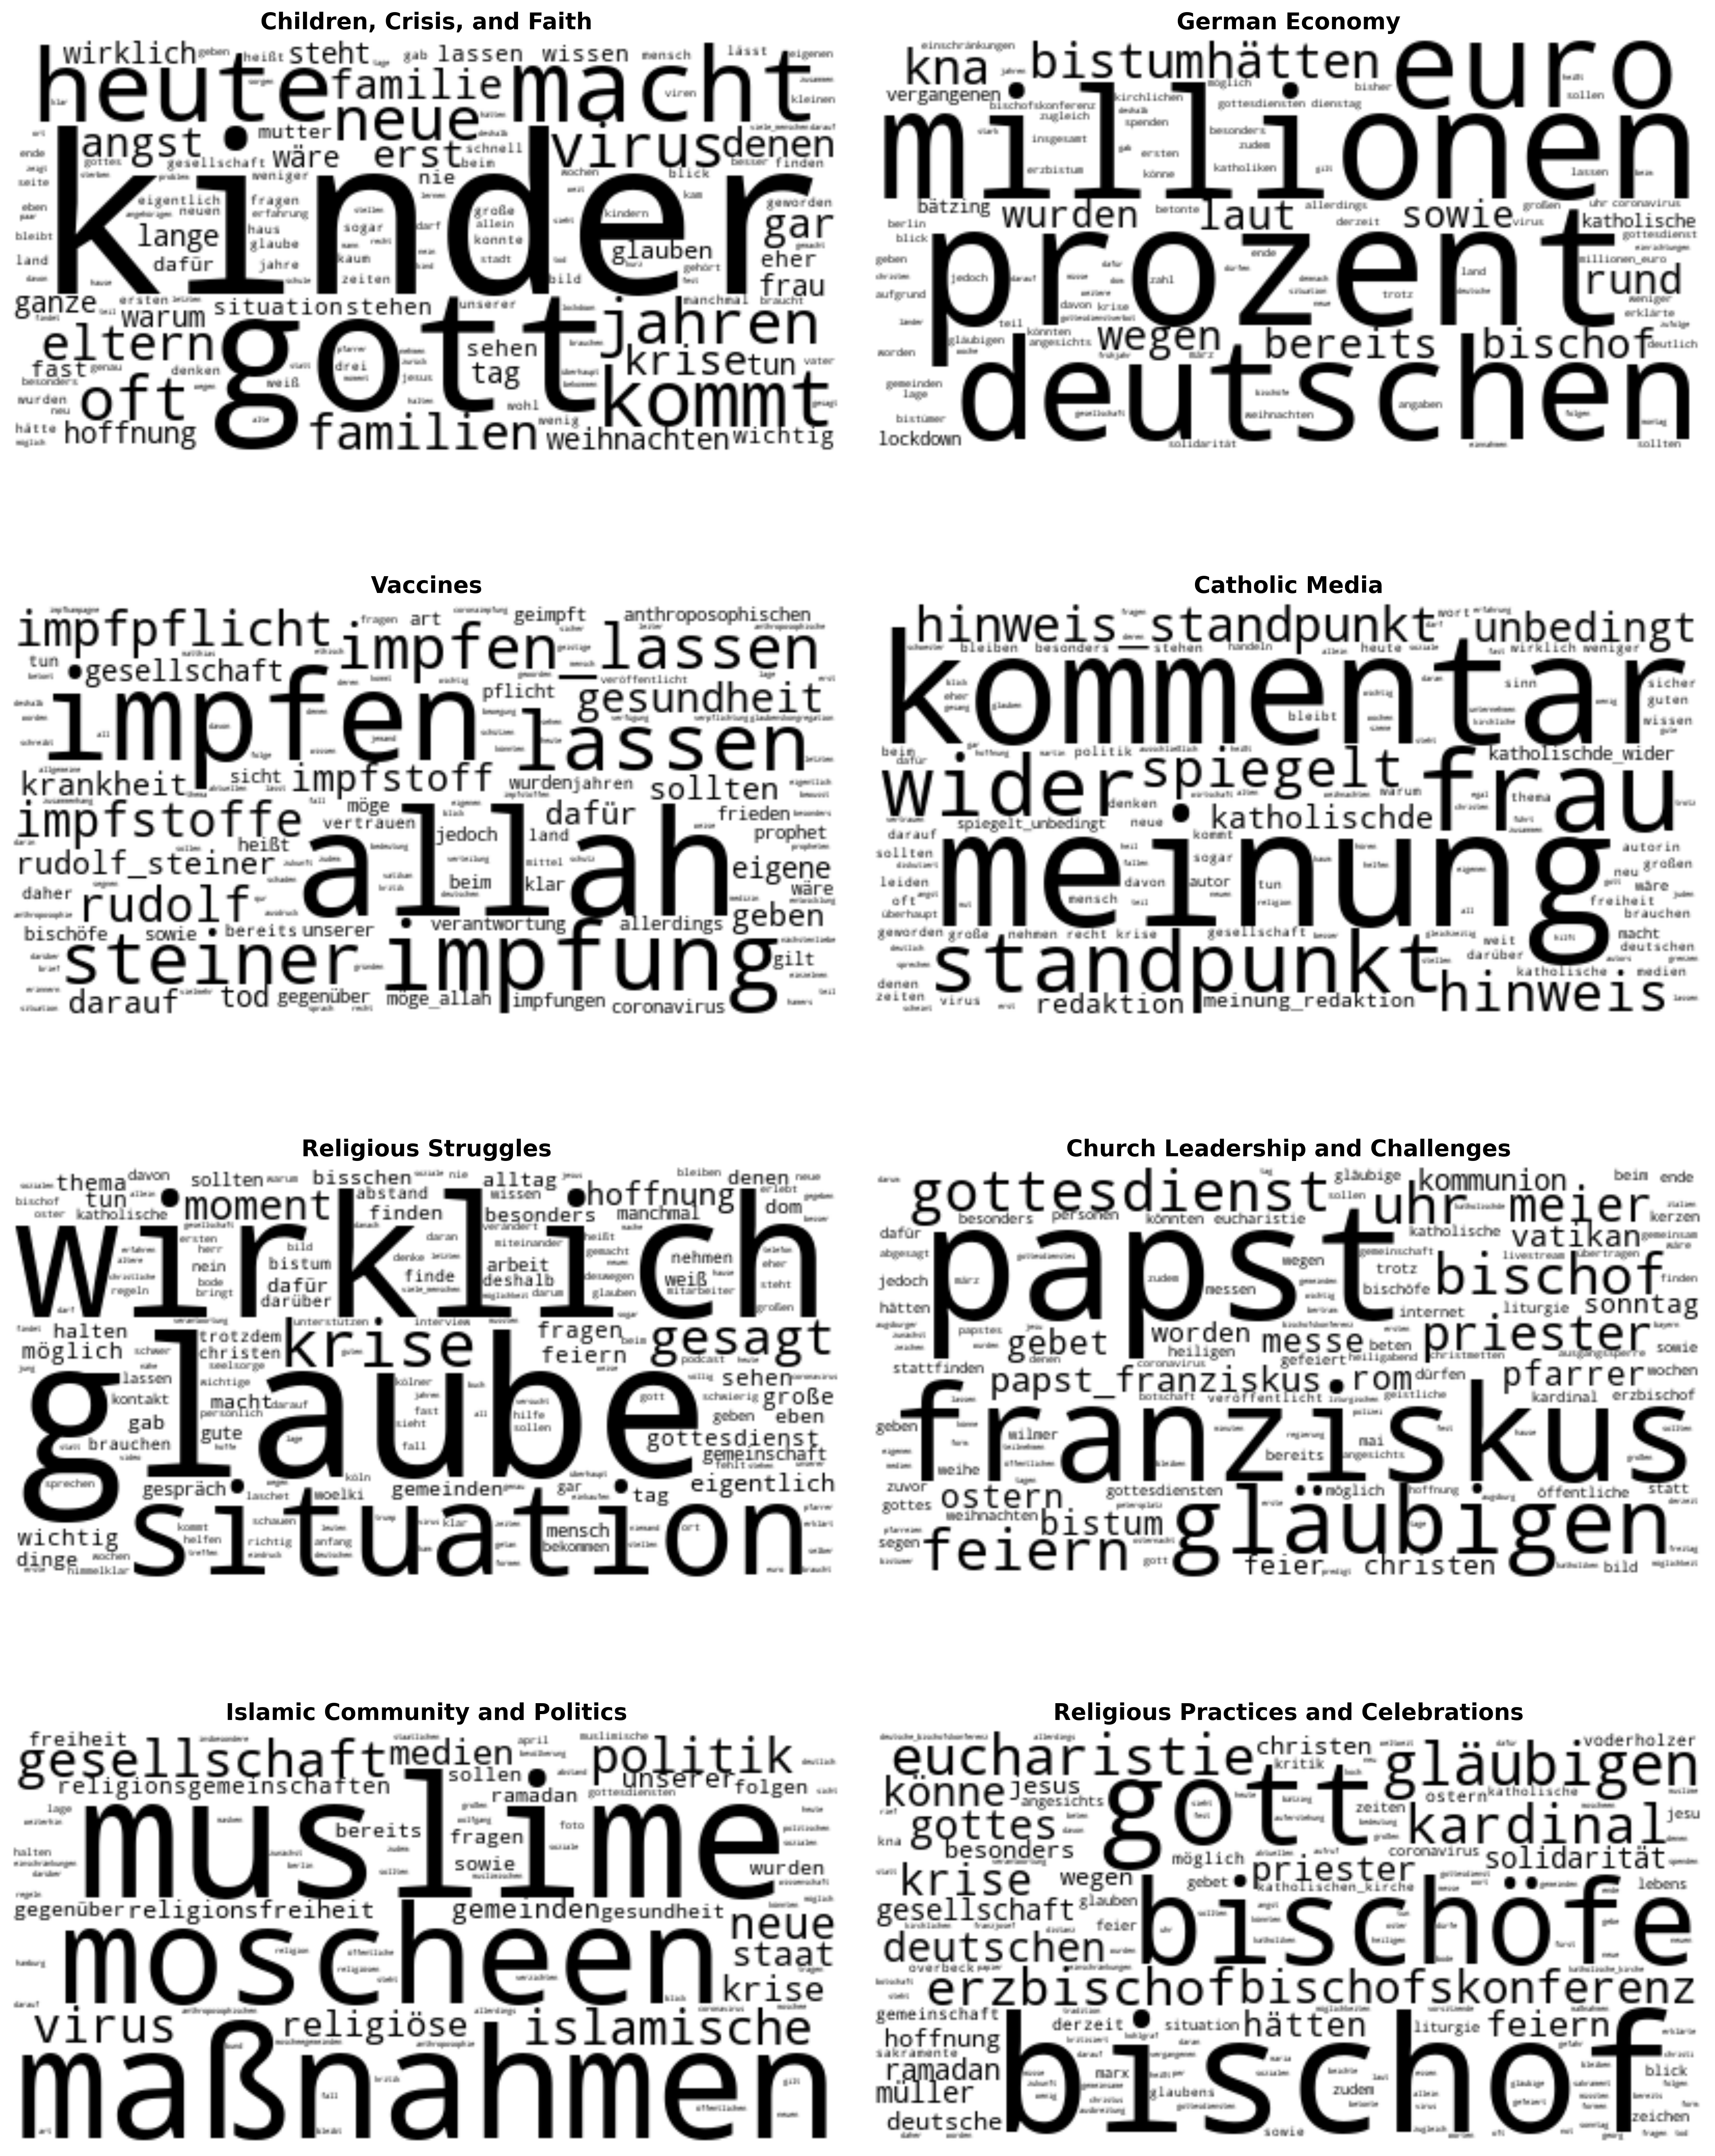

In [24]:
def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "rgb(0, 0, 0)"

font_prop = fm.FontProperties(size=14, weight='bold')

# Assuming you have a trained LDA model named 'model'
num_topics = model.num_topics
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_topics + 1) // num_cols  # Number of rows in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), dpi=300, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=.2)  # Adjust spacing between subplots

for t in range(num_topics):
    row = t // num_cols
    col = t % num_cols

    ax = axes[row, col]
    wordcloud = WordCloud(
        width=400,
        height=200,
        background_color='white',
        color_func=black_color_func,
        prefer_horizontal=1
    ).fit_words(dict(model.show_topic(t, topn=200)))

    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(topic_names[t],fontproperties=font_prop)  # Set the title from the topic_titles list
    
# If there's an odd number of topics, remove the empty subplot
if num_topics % 2 != 0:
    fig.delaxes(axes[num_rows - 1, num_cols - 1])

plt.tight_layout(pad=2.0)  # Adjust padding after all subplots
plt.savefig("deu_rel_lda.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
document_topic_matrix = [list(dict(model.get_document_topics(doc, minimum_probability=0)).values()) for doc in corpus]
df['topics']=document_topic_matrix
expanded_df = df['topics'].apply(pd.Series)
# Concatenate the expanded DataFrame with the original DataFrame along the columns (axis=1)
result_df = pd.concat([df, expanded_df], axis=1)

# Reset the index of the result DataFrame
result_df.reset_index(drop=True, inplace=True)
del result_df['Unnamed: 0']
# result_df.to_excel('../data/clean/deu_rel_lda.xlsx')